01_ML_WS_01_(Payroll_Prediction)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import skew

import pyforest

from yellowbrick.regressor import AlphaSelection, PredictionError, residuals_plot, residuals
from yellowbrick.model_selection import feature_importances, FeatureImportances

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.style.use('classic')
sns.set_style("white")

In [2]:
df = pd.read_csv("payrol_ny_state.csv")

In [3]:
df.sample(2)

,NAME,OFFICE,TITLE,CITY,BIWEEKLT/HOURLY RATE,PAYROL TYPE,PAY PERIOD,LEGISLATIVE ENTITY
594,"LAJAUNIE, SOPHIA M",SENATOR LUIS SEPULVEDA,CHIEF OF STAFF,BRONX,3269.24,RA,4,SENATE EMPLOYEE
776,"NEWMAN, JARED S",SENATOR ANDREA STEWART-COUSINS,EXEC DIR OF SEN DEM INTERN PROGRAM,ALBANY,2115.39,RA,4,SENATE EMPLOYEE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NAME                  1000 non-null   object 
 1   OFFICE                1000 non-null   object 
 2   TITLE                 1000 non-null   object 
 3   CITY                  1000 non-null   object 
 4   BIWEEKLT/HOURLY RATE  1000 non-null   float64
 5   PAYROL TYPE           1000 non-null   object 
 6   PAY PERIOD            1000 non-null   int64  
 7   LEGISLATIVE ENTITY    1000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 62.6+ KB


In [5]:
df.shape

(1000, 8)

In [422]:
df.duplicated().sum()

0

In [423]:
for column in df.select_dtypes("object").columns:
    print(f"Column {column} has \t: {df[column].nunique()} unique values.")

Column NAME has 	: 1000 unique values.
Column OFFICE has 	: 114 unique values.
Column TITLE has 	: 429 unique values.
Column CITY has 	: 55 unique values.
Column PAYROL TYPE has 	: 3 unique values.
Column LEGISLATIVE ENTITY has 	: 2 unique values.


In [424]:
df["PAY PERIOD"].nunique()

1

In [425]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BIWEEKLT/HOURLY RATE,1000.0,2129.12208,1144.883266,11.1,1423.08,1923.08,2692.31,7115.39
PAY PERIOD,1000.0,4.00000,0.000000,4.0,4.00,4.00,4.00,4.00


In [426]:
pd.qcut(df["BIWEEKLT/HOURLY RATE"].sort_values(), q=4).value_counts()

(11.099, 1423.08]     253
(1423.08, 1923.08]    249
(1923.08, 2692.31]    249
(2692.31, 7115.39]    249
Name: BIWEEKLT/HOURLY RATE, dtype: int64

In [427]:
df.skew()
# -1.0 -- +1.0 SUITABLE FOR LINEAR REGRESSION
# -0.5 -- +0.5 NORMAL SKEW
# +0.5 -- +1.0 MODERATE SKEW 
# -1.0 -- +1.0 UPPER LOWER >>> NOT SUITABLE FOR LINEAR REGRESSION

BIWEEKLT/HOURLY RATE    0.929653
PAY PERIOD              0.000000
dtype: float64

In [428]:
df["BIWEEKLT/HOURLY RATE"].mean()

2129.12208

In [429]:
df[df["BIWEEKLT/HOURLY RATE"] < 200].shape

(37, 8)

In [430]:
df["BIWEEKLT/HOURLY RATE"] = df["BIWEEKLT/HOURLY RATE"].map(lambda x : x*80 if x < 200 else x)

In [431]:
df["BIWEEKLT/HOURLY RATE"].min()

230.77

In [432]:
# z-score outlier
# Other approach is IQR
df = df[~df["BIWEEKLT/HOURLY RATE"].transform(lambda x : abs(x-x.mean()) > 1.96*x.std()).values]

In [433]:
# z-table 1.96 std
# Probability = %97.5
# %2.5 for eather sides
# Alpha = %5
# CI = %95

In [434]:
df.shape

(963, 8)

In [435]:
df.tail(2)

,NAME,OFFICE,TITLE,CITY,BIWEEKLT/HOURLY RATE,PAYROL TYPE,PAY PERIOD,LEGISLATIVE ENTITY
998,"SIERZEGA, KIMBERLY",SENATE TECHNOLOGY SERVICES,SENIOR OFFICE SUPPORT REPRESENTATIVE,ALBANY,2917.25,RA,4,SENATE EMPLOYEE
999,"SILVERSTEIN, CHARLES P",MINORITY COUNSEL/PROGRAM,LEGISLATIVE ANALYST,ALBANY,1923.08,RA,4,SENATE EMPLOYEE


In [436]:
df.reset_index(drop=True, inplace=True)

In [437]:
df.tail(2)

,NAME,OFFICE,TITLE,CITY,BIWEEKLT/HOURLY RATE,PAYROL TYPE,PAY PERIOD,LEGISLATIVE ENTITY
961,"SIERZEGA, KIMBERLY",SENATE TECHNOLOGY SERVICES,SENIOR OFFICE SUPPORT REPRESENTATIVE,ALBANY,2917.25,RA,4,SENATE EMPLOYEE
962,"SILVERSTEIN, CHARLES P",MINORITY COUNSEL/PROGRAM,LEGISLATIVE ANALYST,ALBANY,1923.08,RA,4,SENATE EMPLOYEE


In [438]:
df.columns = df.columns.str.capitalize()

In [439]:
df.head(2)

,Name,Office,Title,City,Biweeklt/hourly rate,Payrol type,Pay period,Legislative entity
0,"ABBOT, JUDITH L",SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,4,SENATE EMPLOYEE
1,"ABREU, BRIAN A",LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,4,JOINT LEGISLATIVE EMPLOYEE


In [440]:
for col in df.columns:
    print(f"'{col}' has {df[col].nunique()} unique items")
    if df[col].nunique() == 1 or df[col].nunique() == len(df):
        print(f"\nyou can drop {col} feature \n") 

'Name' has 963 unique items

you can drop Name feature 

'Office' has 112 unique items
'Title' has 406 unique items
'City' has 53 unique items
'Biweeklt/hourly rate' has 417 unique items
'Payrol type' has 3 unique items
'Pay period' has 1 unique items

you can drop Pay period feature 

'Legislative entity' has 2 unique items


In [441]:
df1 = df.drop(["Name","Pay period"], axis=1).copy()
df1.head(2)

,Office,Title,City,Biweeklt/hourly rate,Payrol type,Legislative entity
0,SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,SENATE EMPLOYEE
1,LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,JOINT LEGISLATIVE EMPLOYEE


In [442]:
(df1.Title.value_counts() == 1).sum()

283

In [443]:
(df1.Office.value_counts() == 1).sum()

5

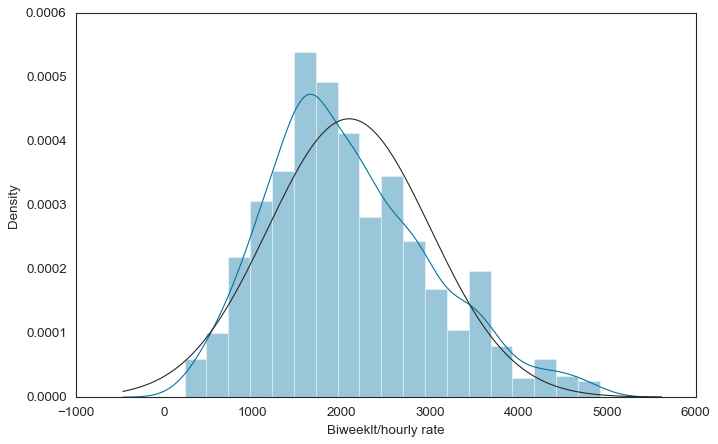

In [444]:
plt.figure(figsize=(10,6))
sns.distplot(df1["Biweeklt/hourly rate"], fit=stats.norm)
plt.tight_layout
plt.show;

In [445]:
stats.skew(df1["Biweeklt/hourly rate"])

0.6036242553202789

In [446]:
list_of_least_title = []

for i in df1.Title.unique():
    if df.Title.value_counts()[i] < 2:
        list_of_least_title.append(i)

list_of_least_title

['SR. DIR. LEG. AFFRS / COMMITTEE DIR.',
 'TECHNICAL SUPPORT REPRESENTATIVE',
 'DISTRICT POLICY & ORGANIZING DIRECTO',
 'EXTERNAL RELATIONS LEGISLATIVE AIDE',
 'DISTRICT OFFICE COORDINATOR',
 'DIRECTOR OF COMMUNITY RELATIONS',
 'TRANSLATOR',
 'EMPLOYEE BENEFITS ASSISTANT',
 'ATTORNEY',
 'EXECUTIVE ASSISTANT/ALBANY OFFICE MA',
 'SENIOR CYBERSECURITY ADVISOR',
 'HEALTH COMMITTEE & POLICY ANALYST',
 'DRIVER',
 'SPECIAL ASSISTANT/SCHEDULER',
 'LAW LIBRARY ASSISTANT',
 'CONSTITUENT SERVICE AIDE',
 'DIRECTOR OF PRODUCTIONS',
 'DIRECTOR OF ECONOMIC DEVELOPMENT',
 'CHIEF OF STAFF, DISTRICT',
 'DOWNSTATE OPERATIONS COORDINATOR',
 'COMMUNITY AFFAIRS COORD / SCHEDULER',
 'ACTING CHIEF OF STAFF',
 'MANAGER STS EDUC. AND SUPPORT',
 'DIRECTOR OF DISTRICT OFCE OPERATIONS',
 'WEB & OPEN PROJECTS COORDINATOR',
 'FISCAL ANALYST',
 'SR. ADVSR AGING POLICY & SPEC. PROJ',
 'ASSISTANT DIRECTOR',
 'ASSISTANT CHIEF OF FURNISHINGS',
 'EXECUTIVE ASSISTANT/COMMITTEE CLERK/',
 'COMPLIANCE ASSISTANT',
 'SHOP SUPER

In [447]:
len(list_of_least_title)

283

In [448]:
df1[df1.Title.isin(list_of_least_title)]

,Office,Title,City,Biweeklt/hourly rate,Payrol type,Legislative entity
3,SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,SENATE EMPLOYEE
10,SENATE TECHNOLOGY SERVICES,TECHNICAL SUPPORT REPRESENTATIVE,ALBANY,1307.70,RA,SENATE EMPLOYEE
13,SENATOR JESSICA RAMOS,DISTRICT POLICY & ORGANIZING DIRECTO,EAST ELMHURST,2000.00,RA,SENATE EMPLOYEE
20,MAJORITY CONFERENCE SERVICES,EXTERNAL RELATIONS LEGISLATIVE AIDE,ALBANY,2115.39,SA,SENATE EMPLOYEE
31,SENATOR SUSAN SERINO,DISTRICT OFFICE COORDINATOR,PUTNAM VALLEY,2307.70,RA,SENATE EMPLOYEE
...,...,...,...,...,...,...
947,SENATOR JAMES SANDERS,TEAM COUNSEL,ALBANY,2500.00,RA,SENATE EMPLOYEE
948,SENATOR ANNA M. KAPLAN,CHIEF OF STAFF/COUNSEL,ALBANY,4615.39,RA,SENATE EMPLOYEE
950,SENATE M&O/POST OFFICE,POSTMASTER,ALBANY,2628.45,RA,SENATE EMPLOYEE
952,MAJORITY COUNSEL/PROGRAM,POLICY ASSISTANT,ALBANY,1538.47,RA,SENATE EMPLOYEE


In [449]:
df1.head(2)

,Office,Title,City,Biweeklt/hourly rate,Payrol type,Legislative entity
0,SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,SENATE EMPLOYEE
1,LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,JOINT LEGISLATIVE EMPLOYEE


In [450]:
df2 = pd.get_dummies(df1, drop_first=True)

In [451]:
df2.sample(2)

,Biweeklt/hourly rate,Office_CH/DOCUMENT ROOM,Office_CH/JOURNAL CLERK'S OFFICE,Office_FO/ACCOUNTS PAYABLE,Office_FO/PAYROLL,Office_LC/DEVELOPMENT OF RURAL RESOURCES,Office_LC/LEGISLATIVE ETHICS COMMISSION,Office_LEGISLATIVE HEALTH SERVICE,Office_LEGISLATIVE LIBRARY,Office_LEGISLATIVE MESSENGER SERVICE,...,City_STATEN ISLAND,City_SYOSSET,City_SYRACUSE,City_UTICA,City_WATERTOWN,City_WILLIAMSVILLE,City_YONKERS,Payrol type_SA,Payrol type_TE,Legislative entity_SENATE EMPLOYEE
62,1220.44,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
631,1923.08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [452]:
def print_evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    R2_score = metrics.r2_score(true, predicted)
    print("MAE \t\t:", mae)
    print("MSE \t\t:", mse)
    print("RMSE \t\t:", rmse)
    print("R2_score \t:", R2_score)

### Train Test Split

In [453]:
from sklearn.model_selection import train_test_split

In [454]:
x = df2.drop("Biweeklt/hourly rate", axis=1)
y = df2["Biweeklt/hourly rate"]

In [455]:
x.shape

(963, 571)

In [456]:
y.shape

(963,)

In [457]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Linear Regression

In [458]:
from sklearn.linear_model import LinearRegression

In [459]:
lin_model = LinearRegression()

In [460]:
lin_model.fit(x_train, y_train)

LinearRegression()

In [461]:
lin_model.score(x_train, y_train) # r2

0.9287153478612411

In [462]:
lin_model.score(x_test, y_test) # r2

-4.477765600564265e+25

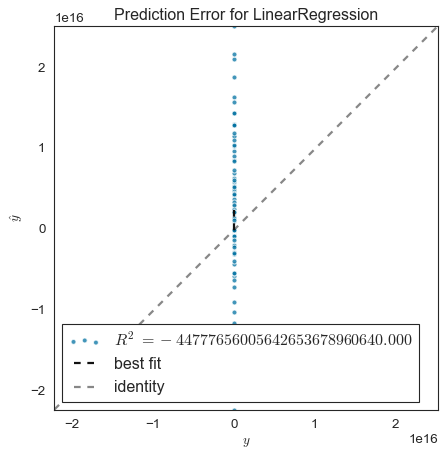

In [463]:
plt.figure(figsize=(8,6))
visualizer = PredictionError(LinearRegression())
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()
plt.tight_layout;

In [464]:
lin_model.intercept_

-4789179156198185.0

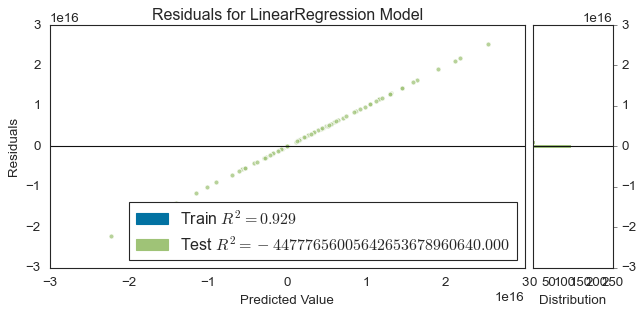

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [465]:
from yellowbrick.regressor.residuals import ResidualsPlot
plt.figure(figsize=(8,4))
model = ResidualsPlot(LinearRegression())
model.fit(x_train, y_train)
model.score(x_test, y_test)
plt.tight_layout()
model.show()

In [466]:
y_test_pred = lin_model.predict(x_test)
y_test_pred

array([ 1.62300000e+03,  3.38400000e+03,  7.89000000e+02,  1.54500000e+03,
        3.09300000e+03, -5.72439966e+15,  8.69995160e+15,  9.96000000e+02,
        1.53500000e+03,  1.40300000e+03,  2.21700000e+03,  3.11600000e+03,
        1.30281275e+16,  1.62700000e+03,  3.59900000e+03,  6.03000000e+02,
        3.41300000e+03, -6.99052227e+15,  9.69000000e+02,  5.50176005e+15,
        2.29500000e+03,  3.06000000e+03,  1.32489619e+15, -6.66566825e+14,
        1.07100000e+03,  7.03000000e+02,  4.00800000e+03,  1.30000000e+03,
        2.25300000e+03,  6.39655729e+15,  1.16252417e+16,  2.96100000e+03,
        9.31000000e+02,  2.34300000e+03, -9.67854147e+14,  2.05400000e+03,
        1.67139409e+15,  2.12000000e+03,  1.85700000e+03,  1.84500000e+03,
        1.47500000e+03,  1.54500000e+03, -1.40797932e+16,  1.84200000e+03,
        2.27300000e+03, -7.05957843e+14,  1.12640865e+15,  2.04700000e+03,
        1.90027478e+16, -4.24712863e+15,  1.31485043e+15,  2.18300000e+03,
        9.81044089e+15,  

In [467]:
my_dict = {"Actual":y_test, "pred":y_test_pred, "residual":y_test-y_test_pred,}

In [468]:
comparing = pd.DataFrame(my_dict)
comparing

,Actual,pred,residual
529,2086.38,1.623000e+03,4.633800e+02
342,2500.00,3.384000e+03,-8.840000e+02
352,1000.00,7.890000e+02,2.110000e+02
819,1571.43,1.545000e+03,2.643000e+01
277,2734.38,3.093000e+03,-3.586200e+02
...,...,...,...
552,3038.91,7.492512e+15,-7.492512e+15
33,1923.08,4.431683e+15,-4.431683e+15
31,2307.70,-8.945302e+15,8.945302e+15
717,1501.01,2.177588e+15,-2.177588e+15


### Ridge

In [469]:
ridge_model = Ridge(random_state=42)

In [470]:
ridge_model.fit(x_train, y_train)

Ridge(random_state=42)

In [471]:
ridge_model.score(x_train, y_train)

0.8494831000302421

In [472]:
ridge_model.score(x_test, y_test)

0.36996091143901644

### Ridge CrossValidate

In [473]:
scores = cross_validate(ridge_model,
                        x_train,
                        y_train,
                        scoring=["r2",
                                "neg_mean_absolute_error",
                                "neg_mean_squared_error",
                                "neg_root_mean_squared_error"],
                        cv=10)

In [474]:
pd.DataFrame(scores)

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.046831,0.011975,0.691615,-370.774048,-231209.109476,-480.842084
1,0.041699,0.011573,0.431356,-536.915009,-480272.490063,-693.016948
2,0.038964,0.009006,0.568630,-478.844679,-445130.704573,-667.181163
3,0.037958,0.006004,0.488462,-456.689719,-453469.392575,-673.401361
4,0.034238,0.007523,0.415478,-525.400082,-488315.943831,-698.796067
5,0.040572,0.011005,0.563989,-500.261000,-401382.791047,-633.547781
6,0.035588,0.010170,0.517789,-477.275000,-445218.497419,-667.246954
7,0.036003,0.011012,0.463081,-523.230823,-504730.050768,-710.443559
8,0.036001,0.006061,0.541121,-408.945232,-318844.818359,-564.663456
9,0.030751,0.009716,0.596816,-423.378331,-311607.992249,-558.218588


In [475]:
pd.DataFrame(scores)["test_r2"].mean()

0.5278337115763037

### Ridge Alpha Tuning

In [476]:
alpha_space = np.linspace(0.01,5,50)

In [477]:
ridgecv = RidgeCV(alphas=alpha_space, cv=10)

In [478]:
ridgecv.fit(x_train, y_train)

RidgeCV(alphas=array([0.01      , 0.11183673, 0.21367347, 0.3155102 , 0.41734694,
       0.51918367, 0.62102041, 0.72285714, 0.82469388, 0.92653061,
       1.02836735, 1.13020408, 1.23204082, 1.33387755, 1.43571429,
       1.53755102, 1.63938776, 1.74122449, 1.84306122, 1.94489796,
       2.04673469, 2.14857143, 2.25040816, 2.3522449 , 2.45408163,
       2.55591837, 2.6577551 , 2.75959184, 2.86142857, 2.96326531,
       3.06510204, 3.16693878, 3.26877551, 3.37061224, 3.47244898,
       3.57428571, 3.67612245, 3.77795918, 3.87979592, 3.98163265,
       4.08346939, 4.18530612, 4.28714286, 4.38897959, 4.49081633,
       4.59265306, 4.6944898 , 4.79632653, 4.89816327, 5.        ]),
        cv=10)

In [479]:
ridgecv.alpha_

1.2320408163265306

In [480]:
ridgecv.best_score_

0.5284070935037756

In [481]:
ridgecv.score(x_train, y_train)

0.8332783229124967

In [482]:
ridgecv.score(x_test, y_test)

0.36955738272989525

In [483]:
ridge_2 = Ridge(alpha=1.2320408163265306, random_state=42)

In [484]:
ridge_2.fit(x_train, y_train)

Ridge(alpha=1.2320408163265306, random_state=42)

In [485]:
ridge_2.score(x_train, y_train)

0.8332783229124967

In [486]:
ridge_2.score(x_test, y_test)

0.36955738272989525

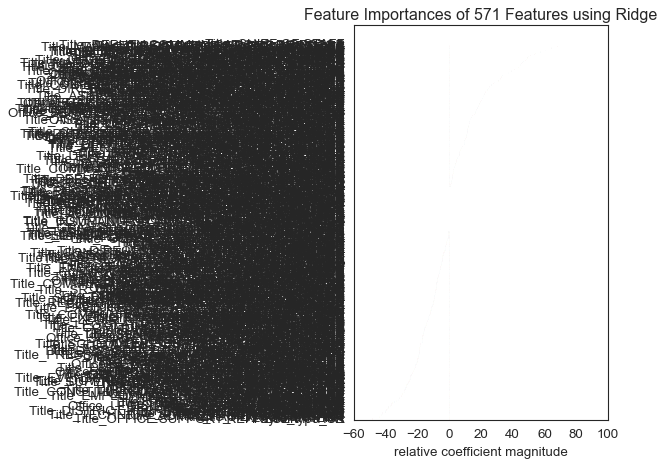

<AxesSubplot:title={'center':'Feature Importances of 571 Features using Ridge'}, xlabel='relative coefficient magnitude'>

In [487]:
viz = FeatureImportances(ridge_2, labels=x.columns)
viz.fit(x_train, y_train)
viz.show()

In [488]:
y_test_pred = ridge_2.predict(x_test)

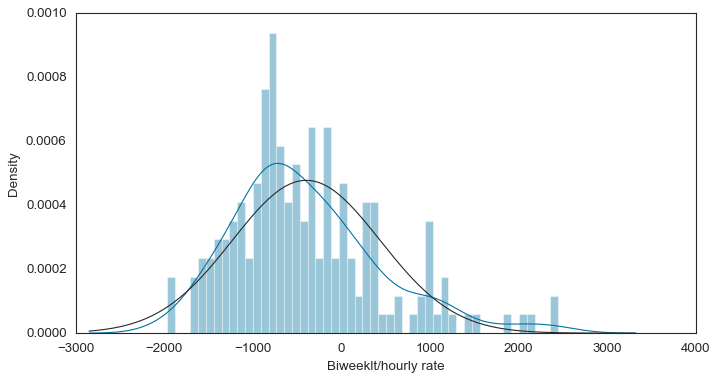

In [489]:
plt.figure(figsize=(10,5))
sns.distplot((y_test - y_test_pred), bins=50, fit=stats.norm);
# For Linear Regression Residuals should be Normal Distrubition

In [490]:
stats.skew(y_test - y_test_pred)
# Skewness for Linear Regression is -1.0 -- +1.0

0.9141633633635053

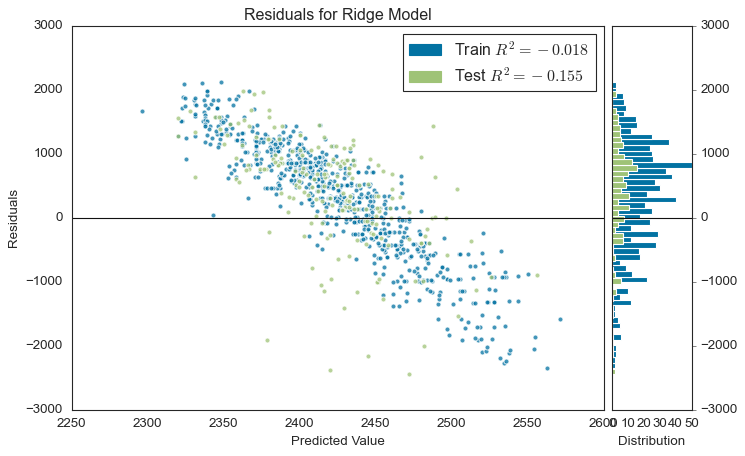

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [491]:
plt.figure(figsize=(10,6))
model = ResidualsPlot(ridge_2)
model.fit(x_train, y_train)
model.score(x_test, y_test)
model.show()

### Lasso

In [492]:
lasso_model = Lasso(random_state=42)

In [493]:
lasso_model.fit(x_train, y_train)

Lasso(random_state=42)

In [494]:
lasso_model.score(x_train, y_train)

0.7823697667590425

In [495]:
lasso_model.score(x_test, y_test)

0.34508278440808104

### Lasso CrossValidate

In [496]:
scores = cross_validate(lasso_model,
                        x_train,
                        y_train,
                        scoring=["r2",
                                "neg_mean_absolute_error",
                                "neg_mean_squared_error",
                                "neg_root_mean_squared_error"],
                        cv=10)

In [497]:
pd.DataFrame(scores)

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.029312,0.010264,0.718153,-368.244571,-211312.530640,-459.687427
1,0.028128,0.008268,0.409856,-554.501431,-498431.616180,-705.996895
2,0.048464,0.011994,0.542147,-506.954329,-472459.070815,-687.356582
3,0.028041,0.009161,0.436698,-477.392641,-499357.495211,-706.652316
4,0.028240,0.009435,0.365513,-561.525939,-530058.079416,-728.050877
5,0.026487,0.006993,0.587852,-475.459911,-379415.239619,-615.966914
6,0.037796,0.008796,0.457776,-516.439232,-500627.159187,-707.550111
7,0.028111,0.009994,0.379154,-554.735753,-583625.585610,-763.953916
8,0.034464,0.010405,0.501041,-442.879757,-346693.555368,-588.806891
9,0.032712,0.006994,0.557860,-440.099454,-341715.632904,-584.564481


In [498]:
pd.DataFrame(scores)["test_r2"].mean()

0.4956048610289403

### Lasso Alpha Tuning

In [499]:
lasso_cv_model = LassoCV(alphas=alpha_space,
                         cv=10,
                         max_iter=100000,
                         n_jobs=-1,
                         random_state=42)

In [500]:
lasso_cv_model.fit(x_train, y_train)

LassoCV(alphas=array([0.01      , 0.11183673, 0.21367347, 0.3155102 , 0.41734694,
       0.51918367, 0.62102041, 0.72285714, 0.82469388, 0.92653061,
       1.02836735, 1.13020408, 1.23204082, 1.33387755, 1.43571429,
       1.53755102, 1.63938776, 1.74122449, 1.84306122, 1.94489796,
       2.04673469, 2.14857143, 2.25040816, 2.3522449 , 2.45408163,
       2.55591837, 2.6577551 , 2.75959184, 2.86142857, 2.96326531,
       3.06510204, 3.16693878, 3.26877551, 3.37061224, 3.47244898,
       3.57428571, 3.67612245, 3.77795918, 3.87979592, 3.98163265,
       4.08346939, 4.18530612, 4.28714286, 4.38897959, 4.49081633,
       4.59265306, 4.6944898 , 4.79632653, 4.89816327, 5.        ]),
        cv=10, max_iter=100000, n_jobs=-1, random_state=42)

In [501]:
lasso_cv_model.alpha_

0.8246938775510204

In [502]:
lasso_cv_model.score(x_train, y_train)

0.811406653383294

In [503]:
lasso_cv_model.score(x_test, y_test)

0.35468256605872395

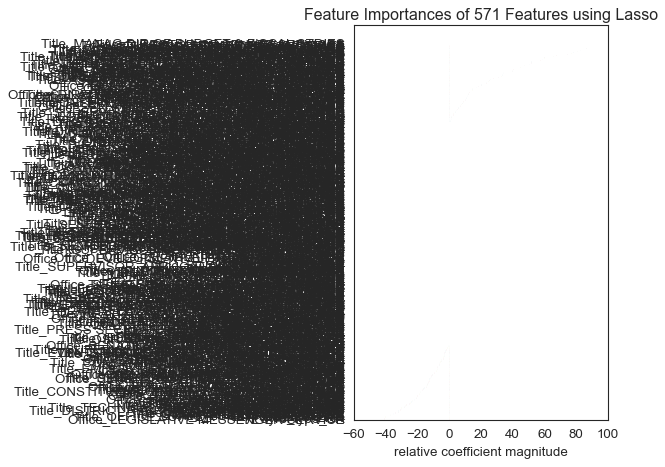

<AxesSubplot:title={'center':'Feature Importances of 571 Features using Lasso'}, xlabel='relative coefficient magnitude'>

In [504]:
viz = FeatureImportances(Lasso(alpha=0.8246938775510204, random_state=42), labels=x.columns)
viz.fit(x_train, y_train)
viz.show()

### ElasticNet

In [506]:
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection="random", random_state=42)

In [507]:
elastic_model.fit(x_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42, selection='random')

In [508]:
elastic_model.score(x_train, y_train)

0.6302576586179983

In [509]:
elastic_model.score(x_test, y_test)

0.31930731289999614

In [510]:
grid_params = {"alpha":alpha_space, "l1_ratio":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [511]:
grid_elastic = GridSearchCV(elastic_model,
                            param_grid=grid_params,
                            n_jobs=-1,
                            verbose=2,
                            cv=10)

In [514]:
grid_elastic.fit(x_train, y_train)

Fitting 10 folds for each of 450 candidates, totalling 4500 fits


GridSearchCV(cv=10,
             estimator=ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42,
                                  selection='random'),
             n_jobs=-1,
             param_grid={'alpha': array([0.01      , 0.11183673, 0.21367347, 0.3155102 , 0.41734694,
       0.51918367, 0.62102041, 0.72285714, 0.82469388, 0.92653061,
       1.02836735, 1.13020408, 1.23204082, 1.33387755, 1.43571429,
       1.53755102, 1.63938776, 1.74122449, 1.84306122, 1.94489796,
       2...6, 2.3522449 , 2.45408163,
       2.55591837, 2.6577551 , 2.75959184, 2.86142857, 2.96326531,
       3.06510204, 3.16693878, 3.26877551, 3.37061224, 3.47244898,
       3.57428571, 3.67612245, 3.77795918, 3.87979592, 3.98163265,
       4.08346939, 4.18530612, 4.28714286, 4.38897959, 4.49081633,
       4.59265306, 4.6944898 , 4.79632653, 4.89816327, 5.        ]),
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9]},
             verbose=2)

In [515]:
grid_elastic.best_params_

{'alpha': 0.01, 'l1_ratio': 0.8}

In [516]:
grid_elastic.best_score_

0.5281742775574574

In [517]:
# 4 Kinds of Model Applied
    # Linear Regression
    # Ridge, RidgeCV
    # Lasso, LassoCV
    # ElasticNet, ElasticNetCV